In [2]:
import openslide

In [3]:
ls

small.svs@  tiler-dev.ipynb


In [4]:
slide = openslide.OpenSlide('small.svs')

In [ ]:
slide

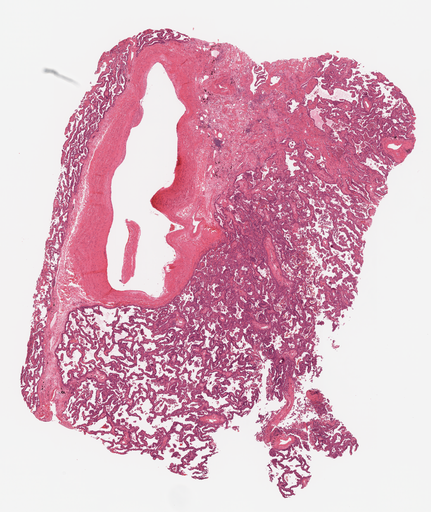

In [11]:
slide.get_thumbnail([512,512])

In [13]:
thumb = slide.get_thumbnail([1024,1024])

In [85]:
slide.read_region?

Signature: slide.read_region(location, level, size)
Docstring:
Return a PIL.Image containing the contents of the region.

location: (x, y) tuple giving the top left pixel in the level 0
          reference frame.
level:    the level number.
size:     (width, height) tuple giving the region size.

Unlike in the C interface, the image data returned by this
function is not premultiplied.
File:      ~/miniconda3/envs/pathology_clock/lib/python3.10/site-packages/openslide/__init__.py
Type:      method

In [12]:
slide.dimensions


(15991, 18986)

In [18]:
pip install opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/f5/d0/2e455d894ec0d6527e662ad55e70c04f421ad83a6fd0a54c3dd73c411282/opencv_python-4.8.0.76-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for numpy>=1.21.2 from https://files.pythonhosted.org/packages/71/3c/3b1981c6a1986adc9ee7db760c0c34ea5b14ac3da9ecfcf1ea2a4ec6c398/numpy-1.25.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 24.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 36.3 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [41]:
# split dicom into tiles
import os.path
from glob import glob

#from joblib import Parallel, delayed
from tqdm import tqdm

import cv2
import numpy as np
from PIL import Image


def reshape_split(image: np.ndarray, kernel_size: tuple):
    #print(image.shape)
    height, width, _ = image.shape
    tHeight, tWidth, _ = kernel_size
    # need to pad
    tR, tC = height//tHeight, width//tWidth
    #print(tR, tC)
    pR, pC = height-tR*tHeight, width-tC*tWidth
    #print(tHeight-pR, tWidth-pC)
    image = np.pad(image, ((0,tHeight-pR), (0, tWidth-pC), (0,0)))
    #print(image.shape)
    height, width, _ = image.shape
    print(image.shape)
    print(height//tHeight, tHeight, width//tWidth, tWidth)
    tiled_array = image.reshape(height//tHeight, tHeight, width//tWidth, tWidth, 3)
    tiled_array = tiled_array.swapaxes(1,2)
    return tiled_array



def makeTiles(img, tileSize):
    #d = pydicom.read_file(dicom)
    #img = d.pixel_array
    tiled = reshape_split(img, (tileSize, tileSize, 3))
    #print(tiled.shape)
    return tiled


tiled = makeTiles(np.asarray(thumb),224)
nRows, nCols = tiled.shape[0], tiled.shape[1]
print(nRows, nCols)
tiled.shape

(1120, 896, 3)
5 224 4 224
5 4


(5, 4, 224, 224, 3)

In [43]:
slide.read_region?

Signature: slide.read_region(location, level, size)
Docstring:
Return a PIL.Image containing the contents of the region.

location: (x, y) tuple giving the top left pixel in the level 0
          reference frame.
level:    the level number.
size:     (width, height) tuple giving the region size.

Unlike in the C interface, the image data returned by this
function is not premultiplied.
File:      ~/miniconda3/envs/pathology_clock/lib/python3.10/site-packages/openslide/__init__.py
Type:      method

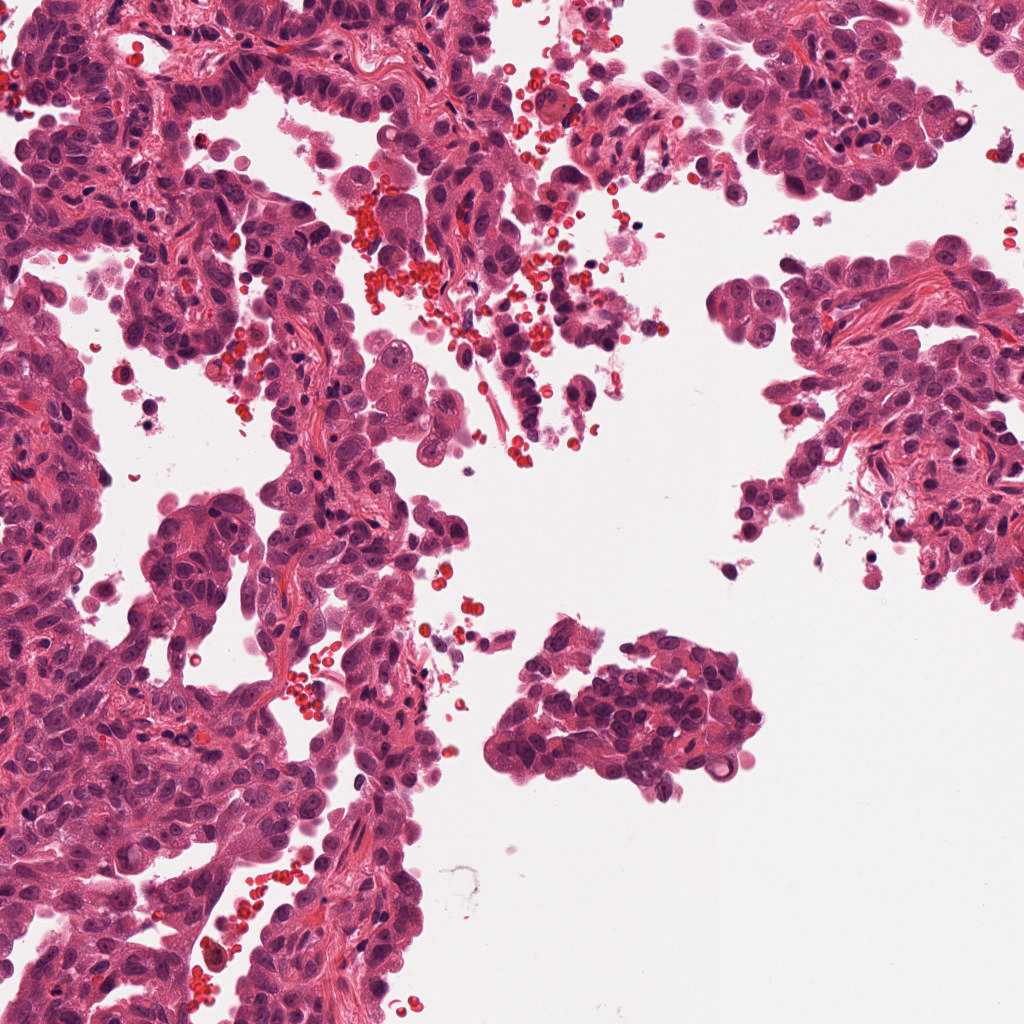

In [68]:
pil=slide.read_region((11*1024,11*1024), 0, (1024,1024))
pil.convert('RGB')

In [70]:
np.count_nonzero(img) / img.size

0.5662851333618164

In [124]:
def fraction_white_pixels(pilImg, thr=200):
    #pil.setflags(write=1)
    img = np.asarray(pilImg.convert('RGB'))#.copy()
    #img.sum(axis=2).max()
    #img.setflags(write=True)\
    #img[np.where((img > [thr, thr, thr]).all(axis=2))] = [0, 0, 0]
    #img[img>200]=0
    #Image.fromarray(img)
    whitePixels = (img > [thr, thr, thr]).all(axis=2)
    h,w,_ = img.shape
    whiteFrac = whitePixels.sum() / whitePixels.size
    return whiteFrac

In [81]:
whiteFrac.sum() / whiteFrac.size

0.4337148666381836

In [78]:
h,w

(1024, 1024)

In [60]:
img.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : False
  ALIGNED : True
  WRITEBACKIFCOPY : False

In [36]:
tiled[0].shape

(4, 224, 224, 3)

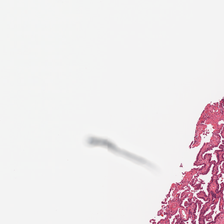

In [39]:
Image.fromarray(tiled[0][0])

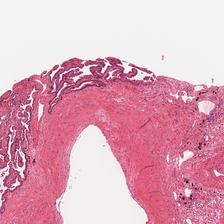

In [40]:
Image.fromarray(tiled[0][1])

In [ ]:
def tile_svs(svsPath, outDir):
    tiled = makeTiles(np.asarray(thumb),224)

In [87]:
slide.dimensions

(15991, 18986)

In [202]:
# yes, this is garbage compared to a meshgrid approach

slideWidth, slideHeight = slide.dimensions
tileSize = 224
tile_coords = []
Y, X = 0, 0
while Y < slideHeight-tileSize:
    while X < slideWidth-tileSize:
        print(Y, X)
        X += tileSize
    Y += tileSize
    X = 0
    break

OpenSlideError: Cannot read raw tile

(71, 84)

In [97]:
tilesX, tilesY = slideWidth//tileSize, slideHeight//tileSize
tilesX, tilesY

(71, 84)

In [100]:
xCoords = np.linspace(0, (tilesX-1)*tileSize, tilesX).astype(int)
yCoords = np.linspace(0, (tilesY-1)*tileSize, tilesY).astype(int)

In [120]:
tile_coordinates = np.dstack(np.meshgrid(xCoords, yCoords))
tile_coordinates.shape

(84, 71, 2)

In [114]:
tile_coordinates.shape

(84, 71, 2)

In [203]:
for row in range(tile_coordinates.shape[0]):
    for col in range(tile_coordinates.shape[1]):
        xPos, yPos = tile_coordinates[row][col]
        print(col, row, (xPos, yPos))
        break

0 0 (0, 0)
0 1 (0, 224)
0 2 (0, 448)
0 3 (0, 672)
0 4 (0, 896)
0 5 (0, 1120)
0 6 (0, 1344)
0 7 (0, 1568)
0 8 (0, 1792)
0 9 (0, 2016)
0 10 (0, 2240)
0 11 (0, 2464)
0 12 (0, 2688)
0 13 (0, 2912)
0 14 (0, 3136)
0 15 (0, 3360)
0 16 (0, 3584)
0 17 (0, 3808)
0 18 (0, 4032)
0 19 (0, 4256)
0 20 (0, 4480)
0 21 (0, 4704)
0 22 (0, 4928)
0 23 (0, 5152)
0 24 (0, 5376)
0 25 (0, 5600)
0 26 (0, 5824)
0 27 (0, 6048)
0 28 (0, 6272)
0 29 (0, 6496)
0 30 (0, 6720)
0 31 (0, 6944)
0 32 (0, 7168)
0 33 (0, 7392)
0 34 (0, 7616)
0 35 (0, 7840)
0 36 (0, 8064)
0 37 (0, 8288)
0 38 (0, 8512)
0 39 (0, 8736)
0 40 (0, 8960)
0 41 (0, 9184)
0 42 (0, 9408)
0 43 (0, 9632)
0 44 (0, 9856)
0 45 (0, 10080)
0 46 (0, 10304)
0 47 (0, 10528)
0 48 (0, 10752)
0 49 (0, 10976)
0 50 (0, 11200)
0 51 (0, 11424)
0 52 (0, 11648)
0 53 (0, 11872)
0 54 (0, 12096)
0 55 (0, 12320)
0 56 (0, 12544)
0 57 (0, 12768)
0 58 (0, 12992)
0 59 (0, 13216)
0 60 (0, 13440)
0 61 (0, 13664)
0 62 (0, 13888)
0 63 (0, 14112)
0 64 (0, 14336)
0 65 (0, 14560)
0 66 (

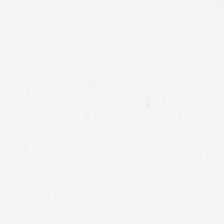

In [113]:
slide.read_region((15680,18592),0,(224,224)).convert('RGB')

In [165]:
pip install pandas

  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/fb/4f/4a4372b2e24439f559b73318683486831d75e59544ae02bf8dec8dd6f48b/pandas-2.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.3/502.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 40.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [137]:
np.dstack(np.meshgrid(xCoords, yCoords)).shape

(84, 71, 2)

In [170]:
import pandas as pd

def tile_WSI(slidePath, outPath, tileSize=384):

    slide = openslide.OpenSlide(str(slidePath))

    slideWidth, slideHeight = slide.dimensions
    tilesX, tilesY = slideWidth//tileSize, slideHeight//tileSize     # grid size
    xCoords = np.linspace(0, (tilesX-1)*tileSize, tilesX).astype(int)
    yCoords = np.linspace(0, (tilesY-1)*tileSize, tilesY).astype(int)

    tile_coordinates = np.dstack(np.meshgrid(xCoords, yCoords))      # shape is (tileRows, tileCols, 2)
    print(tile_coordinates.shape)

    kept_tile_coords = []
    for row in trange(tile_coordinates.shape[0]):
        for col in range(tile_coordinates.shape[1]):
            xPos, yPos = tile_coordinates[row][col]
            tile = slide.read_region((xPos, yPos), 0, (tileSize, tileSize)).convert('RGB')
            wf = fraction_white_pixels(tile)
            if wf > 0.1: continue
            #kept_tile_coords.append(((col, row), (xPos, yPos)))
            kept_tile_coords.append(dict(col=col, row=row, xPos=xPos, yPos=yPos))
            tile.save(str(outPath / f'{col}_{row}.png'))
            #display(tile)
            #break
            #print(col, row, (xPos, yPos))
        #break
    pd.DataFrame(kept_tile_coords).to_csv(str(outPath/'tiles.csv'), index=False)
    return kept_tile_coords

#coords = tile_WSI(slide)
#len(coords)

In [163]:
svs_in = '/srv/dev-disk-by-uuid-ceacc299-7d18-4dfd-8416-889c76bcb7ca/tcga'
png_out = Path('/srv/dev-disk-by-uuid-dc5580b8-bfa8-43e4-a2b8-e111e58bdc38/tcga/png/')
png_out = Path('/nfs/tcga/png/')

In [171]:
slidePath = p
slideFN = p.stem
dataUUID = p.parent.stem
dataUUID, slideFN, slidePath
outPath = png_out/dataUUID/slideFN
print(outPath)

outPath.mkdir(exist_ok=True,parents=True)

tile_WSI(slidePath, outPath)


/nfs/tcga/png/21b63e96-2e2c-4820-8c5f-f39e6cb298fc/TCGA-66-2791-11A-01-TS1.e538c5d3-fe82-4c2f-87df-972dde0ff40a
(49, 119, 2)


100%|██████████████████████████████████████████████████████████████████████████| 49/49 [01:01<00:00,  1.26s/it]


[{'col': 107, 'row': 7, 'xPos': 41088, 'yPos': 2688},
 {'col': 17, 'row': 9, 'xPos': 6528, 'yPos': 3456},
 {'col': 5, 'row': 10, 'xPos': 1920, 'yPos': 3840},
 {'col': 7, 'row': 10, 'xPos': 2688, 'yPos': 3840},
 {'col': 16, 'row': 10, 'xPos': 6144, 'yPos': 3840},
 {'col': 17, 'row': 10, 'xPos': 6528, 'yPos': 3840},
 {'col': 100, 'row': 10, 'xPos': 38400, 'yPos': 3840},
 {'col': 4, 'row': 11, 'xPos': 1536, 'yPos': 4224},
 {'col': 6, 'row': 11, 'xPos': 2304, 'yPos': 4224},
 {'col': 9, 'row': 11, 'xPos': 3456, 'yPos': 4224},
 {'col': 10, 'row': 11, 'xPos': 3840, 'yPos': 4224},
 {'col': 11, 'row': 11, 'xPos': 4224, 'yPos': 4224},
 {'col': 12, 'row': 11, 'xPos': 4608, 'yPos': 4224},
 {'col': 13, 'row': 11, 'xPos': 4992, 'yPos': 4224},
 {'col': 17, 'row': 11, 'xPos': 6528, 'yPos': 4224},
 {'col': 51, 'row': 11, 'xPos': 19584, 'yPos': 4224},
 {'col': 4, 'row': 12, 'xPos': 1536, 'yPos': 4608},
 {'col': 11, 'row': 12, 'xPos': 4224, 'yPos': 4608},
 {'col': 49, 'row': 12, 'xPos': 18816, 'yPos': 46

In [ ]:
outPath.m

In [146]:
from pathlib import Path
for p in Path('/nfs/tcga/svs_methyl/').glob('*/*.svs'):
    print(p)
    break

/nfs/tcga/svs_methyl/21b63e96-2e2c-4820-8c5f-f39e6cb298fc/TCGA-66-2791-11A-01-TS1.e538c5d3-fe82-4c2f-87df-972dde0ff40a.svs


In [150]:
p.parent.stem

'21b63e96-2e2c-4820-8c5f-f39e6cb298fc'